In [ ]:
#########################################################################################
#                                                                                       #
#                 Projet de prédiction, via l’apprentissage automatique :               #
#                                                                                       #
#########################################################################################

In [1]:
from bs4 import BeautifulSoup
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#################################################################
#       Premier jalon : récupération des données en python      #
#################################################################

In [3]:
# Q1
def getsoup(url):
    return BeautifulSoup(requests.get(url).text,'html.parser')

In [4]:
# Q2 
class NonValide(Exception):
    pass

In [5]:
# Q3
def prix(soup):
    try:
        prix_tag=soup.find("p", class_="product-price")
        prix_text=prix_tag.text.replace("€", "").replace(" ", "").strip()
        prix=int(prix_text)
        if prix<10000:
            raise NonValide("Prix trop bas.")
        return prix
    except:
        raise NonValide("Prix non trouvé")

In [6]:
#Q4
def ville(soup):
    try:
        ville_tag=soup.find("h2", class_="mt-0")
        ville_text=ville_tag.text.strip()
        dernier_index=ville_text.rfind(", ")
        ville=ville_text[dernier_index+2:]
        return ville
    except:
        raise NonValide("Ville non trouvée.")

In [7]:
# Q5
def caracteristiques(soup):
    caracteristiques_balise = soup.find('p', class_='ad-section-title')
    if not caracteristiques_balise:
        raise NonValide("Caractéristiques non trouvées")
    
    return caracteristiques_balise.find_next("div") 

def type(soup):
    caracteristique = caracteristiques(soup)
    try:
        type_tag=caracteristique.find("span",string="Type")
        type=type_tag.find_next("span").text.strip()
        if type not in ["Maison","Appartement"]:
            raise NonValide("Type non valide.")
        return type
    except:
        raise NonValide("Type non trouvé.")

def surface(soup):
    caracteristique = caracteristiques(soup)
    surface_tag=caracteristique.find("span", string="Surface")
    if surface_tag:
        surface=surface_tag.find_next("span").text.replace("m²", "").strip()
        return surface
    return "-"

def nbrpieces(soup):
    caracteristique = caracteristiques(soup)
    nbrpieces_tag=caracteristique.find("span",string="Nb. de pièces")
    if nbrpieces_tag:
        nbrpieces=nbrpieces_tag.find_next("span").text.strip()
        return nbrpieces
    return "-"

def nbrchambres(soup):
    caracteristique = caracteristiques(soup)
    nbrchambres_tag=caracteristique.find("span",string="Nb. de chambres")
    if nbrchambres_tag:
        nbrchambres=nbrchambres_tag.find_next("span").text.strip()
        return nbrchambres
    return "-"

def nbrsdb(soup):
    caracteristique = caracteristiques(soup)
    nbrsdb_tag=caracteristique.find("span",string="Nb. de sales de bains")
    if nbrsdb_tag:
        nbrsdb=nbrsdb_tag.find_next("span").text.strip()
        return nbrsdb
    return "-"

def dpe(soup):
    caracteristique = caracteristiques(soup)
    dpe_tag = caracteristique.find("span", string="Consommation d'énergie (DPE)")
    if dpe_tag:
        dpe = dpe_tag.find_next("span").text.strip()
        if '(' in dpe:
            dpe = dpe.split('(')[0].strip()
        return dpe
    return "-"

In [8]:
# Q6
def informations(soup):
    try:
        ville_str = ville(soup)
        type_str = type(soup)
        surface_str = surface(soup)
        nbrpieces_str = nbrpieces(soup)
        nbrchambres_str = nbrchambres(soup)
        nbrsdb_str = nbrsdb(soup)
        dpe_str = dpe(soup)
        prix_str = prix(soup)

        return f"{ville_str},{type_str},{surface_str},{nbrpieces_str},{nbrchambres_str},{nbrsdb_str},{dpe_str},{prix_str}"
    except NonValide as e:
        raise NonValide(f"{e}")

In [9]:
# Q7
def get_max_page(soup):
    pagination = soup.select("ul.pagination li a")
    if pagination:
        nbDePages = [int(link.text) for link in pagination if link.text.isdigit()]
        return max(nbDePages) if nbDePages else 1
    return 1

def annonces_CSV():
    url = "https://www.immo-entre-particuliers.com/annonces/france-ile-de-france/vente"
    soup = getsoup(url)
    max_page = get_max_page(soup) 
    print(f"Total de pages : {max_page}")

    annonces_data = []
    annonces_urls = set()

    for page in range(1, max_page + 1): 
        page_url = f"https://www.immo-entre-particuliers.com/annonces/france-ile-de-france/vente/{page}"
        print(f"Page : {page}")
        soup = getsoup(page_url)

        annonces = soup.select('a[href^="/annonce-"]')
        
        for annonce in annonces:
            annonce_url = annonce['href']
            if not annonce_url.startswith("http"):
                annonce_url = "https://www.immo-entre-particuliers.com" + annonce_url
            
            if annonce_url in annonces_urls:
                continue  
            annonces_urls.add(annonce_url)

            try:
                annonce_soup = getsoup(annonce_url)  
                info = informations(annonce_soup)
                if info:
                    annonces_data.append(info)
                    print(f"{info}")
            except NonValide as e:
                print(f"Annonce invalide {annonce_url} : {e}")
                continue  

    if annonces_data:
        with open("annonces.csv", "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["Ville", "Type", "Surface", "NbrPieces", "NbrChambres", "NbrSdb", "DPE", "Prix"])
            for row in annonces_data:
                writer.writerow(row.split(','))

        print("Fini")

annonces_CSV()

Total de pages : 129
Page : 1
Antony,Appartement,70,4,3,-,E,217000
Élancourt,Maison,143,6,4,1,D,510000
Aubergenville,Appartement,39,2,1,1,F,109000
Sognolles-en-Montois,Maison,126,5,3,1,C,190000
Versailles,Appartement,20,1,1,-,E,145000
Meudon,Appartement,83,4,3,-,A,485000
Clamart,Appartement,74,4,2,1,D,360000
Saint-Leu-la-Forêt,Maison,347,12,7,3,F,995000
Annonce invalide https://www.immo-entre-particuliers.com/annonce-seine-saint-denis-bobigny/409497-vente-dunterrain-de-construction-dune-maison-r-2-tetouan-maroc : Type non trouvé.
Nogent-sur-Marne,Appartement,33,1,1,-,D,106000
Beaumont-sur-Oise,Maison,130,7,5,1,E,349900
Pantin,Appartement,77,3,2,1,D,440000
Paris 19ème,Appartement,15,1,-,-,E,154000
Thomery,Maison,95,5,3,-,D,349000
Montreuil,Appartement,31,1,1,-,B,245000
Page : 2
Sainte-Mesme,Maison,136,7,4,1,D,375000
Saint-Cyr-sous-Dourdan,Maison,170,7,3,1,E,420000
Neuilly-sur-Seine,Appartement,14,1,1,-,E,189000
Champs-sur-Marne,Maison,194,9,6,1,D,615000
Morangis,Maison,160,7,4,2,C,38000

In [10]:
#################################################################
#             Deuxième jalon : Nettoyage des données            #
#################################################################

In [11]:
# Q8
annonces = pd.read_csv("annonces.csv")
display(annonces)

,Ville,Type,Surface,NbrPieces,NbrChambres,NbrSdb,DPE,Prix
0,Antony,Appartement,70,4,3,-,E,217000
1,Élancourt,Maison,143,6,4,1,D,510000
2,Aubergenville,Appartement,39,2,1,1,F,109000
3,Sognolles-en-Montois,Maison,126,5,3,1,C,190000
4,Versailles,Appartement,20,1,1,-,E,145000
...,...,...,...,...,...,...,...,...
437,Nogent-sur-Marne,Appartement,76,4,3,1,-,280000
438,Chelles,Maison,150,-,4,2,-,200000
439,Sarcelles,Maison,-,5,3,2,-,345000
440,Pontoise,Appartement,131,6,5,2,-,250000


In [12]:
# Q9
annonces["DPE"] = annonces["DPE"].replace("-", "Vierge")
display(annonces)

,Ville,Type,Surface,NbrPieces,NbrChambres,NbrSdb,DPE,Prix
0,Antony,Appartement,70,4,3,-,E,217000
1,Élancourt,Maison,143,6,4,1,D,510000
2,Aubergenville,Appartement,39,2,1,1,F,109000
3,Sognolles-en-Montois,Maison,126,5,3,1,C,190000
4,Versailles,Appartement,20,1,1,-,E,145000
...,...,...,...,...,...,...,...,...
437,Nogent-sur-Marne,Appartement,76,4,3,1,Vierge,280000
438,Chelles,Maison,150,-,4,2,Vierge,200000
439,Sarcelles,Maison,-,5,3,2,Vierge,345000
440,Pontoise,Appartement,131,6,5,2,Vierge,250000


In [13]:
# Q10
cols = ["Surface", "NbrPieces", "NbrChambres", "NbrSdb"]

annonces[cols] = annonces[cols].replace("-", np.nan)
annonces[cols] = annonces[cols].astype(float)
moyenne = annonces[cols].mean()
annonces[cols] = annonces[cols].fillna(moyenne[cols])

annonces.dropna(inplace=True)

print(moyenne)
display(annonces)

Surface        94.605991
NbrPieces       5.898618
NbrChambres     2.567961
NbrSdb          1.322917
dtype: float64


,Ville,Type,Surface,NbrPieces,NbrChambres,NbrSdb,DPE,Prix
0,Antony,Appartement,70.000000,4.000000,3.0,1.322917,E,217000
1,Élancourt,Maison,143.000000,6.000000,4.0,1.000000,D,510000
2,Aubergenville,Appartement,39.000000,2.000000,1.0,1.000000,F,109000
3,Sognolles-en-Montois,Maison,126.000000,5.000000,3.0,1.000000,C,190000
4,Versailles,Appartement,20.000000,1.000000,1.0,1.322917,E,145000
...,...,...,...,...,...,...,...,...
437,Nogent-sur-Marne,Appartement,76.000000,4.000000,3.0,1.000000,Vierge,280000
438,Chelles,Maison,150.000000,5.898618,4.0,2.000000,Vierge,200000
439,Sarcelles,Maison,94.605991,5.000000,3.0,2.000000,Vierge,345000
440,Pontoise,Appartement,131.000000,6.000000,5.0,2.000000,Vierge,250000


In [14]:
##      Colonnes “Type" et “DPE”

In [15]:
# Q11
annonces = pd.get_dummies(annonces, columns=["Type", "DPE"], dtype='int')
display(annonces)

,Ville,Surface,NbrPieces,NbrChambres,NbrSdb,Prix,Type_Appartement,Type_Maison,DPE_A,DPE_B,DPE_C,DPE_D,DPE_E,DPE_F,DPE_Vierge
0,Antony,70.000000,4.000000,3.0,1.322917,217000,1,0,0,0,0,0,1,0,0
1,Élancourt,143.000000,6.000000,4.0,1.000000,510000,0,1,0,0,0,1,0,0,0
2,Aubergenville,39.000000,2.000000,1.0,1.000000,109000,1,0,0,0,0,0,0,1,0
3,Sognolles-en-Montois,126.000000,5.000000,3.0,1.000000,190000,0,1,0,0,1,0,0,0,0
4,Versailles,20.000000,1.000000,1.0,1.322917,145000,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,Nogent-sur-Marne,76.000000,4.000000,3.0,1.000000,280000,1,0,0,0,0,0,0,0,1
438,Chelles,150.000000,5.898618,4.0,2.000000,200000,0,1,0,0,0,0,0,0,1
439,Sarcelles,94.605991,5.000000,3.0,2.000000,345000,0,1,0,0,0,0,0,0,1
440,Pontoise,131.000000,6.000000,5.0,2.000000,250000,1,0,0,0,0,0,0,0,1


In [16]:
##      Colonne “Ville”

In [17]:
# Q12
villes = pd.read_csv("cities.csv")

In [18]:
# Q13
villes = pd.read_csv("cities.csv")
annonces["Ville"] = (
    annonces["Ville"]
    .str.lower()  
    .str.replace("-", " ", regex=True) 
    .str.replace("'", "", regex=True)  
    .str.replace(r"[éèê]", "e", regex=True) 
    .str.replace(r"[ô]", "o", regex=True)  
    .str.replace(r"[î]", "i", regex=True)  
    .str.replace(r"[û]", "u", regex=True)  
    .str.replace(r"[à]", "a", regex=True)  
)
display(annonces)


,Ville,Surface,NbrPieces,NbrChambres,NbrSdb,Prix,Type_Appartement,Type_Maison,DPE_A,DPE_B,DPE_C,DPE_D,DPE_E,DPE_F,DPE_Vierge
0,antony,70.000000,4.000000,3.0,1.322917,217000,1,0,0,0,0,0,1,0,0
1,elancourt,143.000000,6.000000,4.0,1.000000,510000,0,1,0,0,0,1,0,0,0
2,aubergenville,39.000000,2.000000,1.0,1.000000,109000,1,0,0,0,0,0,0,1,0
3,sognolles en montois,126.000000,5.000000,3.0,1.000000,190000,0,1,0,0,1,0,0,0,0
4,versailles,20.000000,1.000000,1.0,1.322917,145000,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,nogent sur marne,76.000000,4.000000,3.0,1.000000,280000,1,0,0,0,0,0,0,0,1
438,chelles,150.000000,5.898618,4.0,2.000000,200000,0,1,0,0,0,0,0,0,1
439,sarcelles,94.605991,5.000000,3.0,2.000000,345000,0,1,0,0,0,0,0,0,1
440,pontoise,131.000000,6.000000,5.0,2.000000,250000,1,0,0,0,0,0,0,0,1


In [19]:
villes["label"] = (
    villes["label"]
    .str.lower()
    .str.replace("-", " ", regex=True)
    .str.replace("'", "", regex=True)
    .str.replace(r"[éèê]", "e", regex=True)
    .str.replace(r"[ô]", "o", regex=True)
    .str.replace(r"[î]", "i", regex=True)
    .str.replace(r"[û]", "u", regex=True)
    .str.replace(r"[à]", "a", regex=True)
)
villes.to_csv("cities.csv", index=False)
display(villes)

,insee_code,city_code,zip_code,label,latitude,longitude,department_name,department_number,region_name,region_geojson_name
0,25620,ville du pont,25650,ville du pont,46.999873,6.498147,doubs,25,bourgogne-franche-comté,Bourgogne-Franche-Comté
1,25624,villers grelot,25640,villers grelot,47.361512,6.235167,doubs,25,bourgogne-franche-comté,Bourgogne-Franche-Comté
2,25615,villars les blamont,25310,villars les blamont,47.368384,6.871415,doubs,25,bourgogne-franche-comté,Bourgogne-Franche-Comté
3,25619,les villedieu,25240,les villedieu,46.713906,6.265831,doubs,25,bourgogne-franche-comté,Bourgogne-Franche-Comté
4,25622,villers buzon,25170,villers buzon,47.228558,5.852187,doubs,25,bourgogne-franche-comté,Bourgogne-Franche-Comté
...,...,...,...,...,...,...,...,...,...,...
39140,98829,thio,98829,thio,NaN,NaN,nouvelle-calédonie,988,nouvelle-calédonie,Nouvelle Calédonie
39141,98831,voh,98833,voh,NaN,NaN,nouvelle-calédonie,988,nouvelle-calédonie,Nouvelle Calédonie
39142,98832,yate,98834,yate,NaN,NaN,nouvelle-calédonie,988,nouvelle-calédonie,Nouvelle Calédonie
39143,98612,sigave,98620,sigave,-14.270411,-178.155263,wallis-et-futuna,986,wallis-et-futuna,Wallis-et-Futuna


In [20]:
#Q14
annonces = annonces.merge(villes[['label', 'latitude', 'longitude']], left_on="Ville", right_on="label")

annonces.drop(columns=["Ville", "label"], inplace=True)

annonces.to_csv("annonces.csv", index=False)
display(annonces)

,Surface,NbrPieces,NbrChambres,NbrSdb,Prix,Type_Appartement,Type_Maison,DPE_A,DPE_B,DPE_C,DPE_D,DPE_E,DPE_F,DPE_Vierge,latitude,longitude
0,70.000000,4.000000,3.0,1.322917,217000,1,0,0,0,0,0,1,0,0,48.749987,2.299028
1,143.000000,6.000000,4.0,1.000000,510000,0,1,0,0,0,1,0,0,0,48.778351,1.960992
2,39.000000,2.000000,1.0,1.000000,109000,1,0,0,0,0,0,0,1,0,48.962721,1.849560
3,39.000000,2.000000,1.0,1.000000,109000,1,0,0,0,0,0,0,1,0,48.962721,1.849560
4,126.000000,5.000000,3.0,1.000000,190000,0,1,0,0,1,0,0,0,0,48.518703,3.153103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,150.000000,5.898618,4.0,2.000000,200000,0,1,0,0,0,0,0,0,1,48.883978,2.597093
385,94.605991,5.000000,3.0,2.000000,345000,0,1,0,0,0,0,0,0,1,48.990237,2.381117
386,131.000000,6.000000,5.0,2.000000,250000,1,0,0,0,0,0,0,0,1,49.051578,2.094574
387,131.000000,6.000000,5.0,2.000000,250000,1,0,0,0,0,0,0,0,1,49.051578,2.094574


In [ ]:
#   TEST
villes.to_csv("cities.csv", index=False)

annonces.to_csv("annonces.csv", index=False)

print(annonces.to_string())
print(annonces.info())
print(moyenne)

In [22]:
#################################################################
#               Troisième jalon : Apprentissage                 #
#################################################################

In [23]:
##      Préparation de données d’apprentissage et de test

In [24]:
# Q15
X=annonces.drop(columns=["Prix"])
y=annonces["Prix"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=49)

In [25]:
##      Premier modèle : Régression Linéaire

In [26]:
# Q16
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
print("Régression linéaire R2_score:", r2_lr)

Régression linéaire R2_score: 0.358512651401524


In [27]:
# Q17
lr_norm = make_pipeline(MinMaxScaler(), LinearRegression())
lr_norm.fit(X_train, y_train)
y_pred_lr_norm = lr_norm.predict(X_test)
r2_lr_norm = r2_score(y_test, y_pred_lr_norm)
print("Normalisation LR:", r2_lr_norm)

lr_std = make_pipeline(StandardScaler(), LinearRegression())
lr_std.fit(X_train, y_train)
y_pred_lr_std = lr_std.predict(X_test)
r2_lr_std = r2_score(y_test, y_pred_lr_std)
print("Standardisation LR:", r2_lr_std)

Normalisation LR: 0.358512651401524
Standardisation LR: 0.3585126514015242


In [28]:
# Q18
print("\nMéthode\t\t\t\tR² Score")
print("-" * 40)
print(f"LR\t\t\t\t{r2_lr:.4f}")
print(f"Normalisation + LR\t\t{r2_lr_norm:.4f}")
print(f"Standardisation + LR\t\t{r2_lr_std:.4f}\n")

# Il n'y a pas d'amélioration des prédictions due au pré-traitement pour ce jeu de données et cette méthode.


Méthode				R² Score
----------------------------------------
LR				0.3585
Normalisation + LR		0.3585
Standardisation + LR		0.3585



In [29]:
##      Deuxième modèle : Arbre de Décision

In [30]:
# Q19
for depth in range (4,10):
    ad_depth=DecisionTreeRegressor(max_depth=depth, random_state=49)
    ad_depth.fit(X_train, y_train)
    y_pred_ad_depth=ad_depth.predict(X_test)
    r2_ad_depth=r2_score(y_test, y_pred_ad_depth)
    print(f"R^2 Score (Decision Tree, max_depth={depth}): {r2_ad_depth}")

ad=DecisionTreeRegressor(max_depth=7)
ad.fit(X_train, y_train)
y_pred_ad=ad.predict(X_test)
r2_ad=r2_score(y_test, y_pred_ad)

ad_norm=make_pipeline(MinMaxScaler(), DecisionTreeRegressor(max_depth=7))
ad_norm.fit(X_train, y_train)
y_pred_ad_norm=ad_norm.predict(X_test)
r2_ad_norm=r2_score(y_test, y_pred_ad_norm)

ad_std=make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=7))
ad_std.fit(X_train, y_train)
y_pred_ad_std=ad_std.predict(X_test)
r2_ad_std=r2_score(y_test, y_pred_ad_std)

# L’augmentation de max_depth améliore les résultats, jusqu’à max_depth=7, après quoi la performance diminue.
# Le pré-traitement améliore légèrement les prédictions.
# Les scores obtenus sont satisfaisants.
# On va conserver max_depth=7.

R^2 Score (Decision Tree, max_depth=4): 0.3407455879574831
R^2 Score (Decision Tree, max_depth=5): 0.4971737441121169
R^2 Score (Decision Tree, max_depth=6): 0.4520200313670705
R^2 Score (Decision Tree, max_depth=7): 0.5225162066510229
R^2 Score (Decision Tree, max_depth=8): 0.4620756280644498
R^2 Score (Decision Tree, max_depth=9): 0.361122177052852


In [31]:
# Q20
print("\nMéthode\t\t\t\tR² Score")
print("-" * 40)
print(f"AD\t\t{r2_ad:.4f}")
print(f"Normalisation + AD\t\t{r2_ad_norm:.4f}")
print(f"Standardisation + AD\t\t{r2_ad_std:.4f}\n")


Méthode				R² Score
----------------------------------------
AD		0.5250
Normalisation + AD		0.5177
Standardisation + AD		0.5268



In [32]:
##      Troisième modèle : N plus proches voisins

In [33]:
# Q21
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN (n=4) sans prétraitement:", r2_knn)

knn_norm = make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=4))
knn_norm.fit(X_train, y_train)
y_pred_knn_norm = knn_norm.predict(X_test)
r2_knn_norm = r2_score(y_test, y_pred_knn_norm)
print("KNN + Normalisation:", r2_knn_norm)

knn_std = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=4))
knn_std.fit(X_train, y_train)
y_pred_knn_std = knn_std.predict(X_test)
r2_knn_std = r2_score(y_test, y_pred_knn_std)
print("KNN + Standardisation:", r2_knn_std)

# Standardisation + KNN avec n=5
knn_std_5 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5))
knn_std_5.fit(X_train, y_train)
y_pred_knn_std5 = knn_std_5.predict(X_test)
r2_knn_std_5 = r2_score(y_test, y_pred_knn_std5)
print("KNN + Standardisation (n=5):", r2_knn_std_5)
#La méthode des K plus proches voisins (KNN) offre les meilleurs résultats avec un score R2 de 0.3708. Passer de n_neighbors=4 à n_neighbors=5 n’a pas significativement amélioré les performances, donc garder n=4.

KNN (n=4) sans prétraitement: 0.34463466598540327
KNN + Normalisation: 0.3707703923103164
KNN + Standardisation: 0.30279290625944844
KNN + Standardisation (n=5): 0.3431298794616464


In [34]:
# Q22
print("\nMéthode\t\t\t\tR² Score")
print("-" * 40)
print(f"KNN\t\t\t\t{r2_knn:.4f}")
print(f"Normalisation + KNN\t\t{r2_knn_norm:.4f}")
print(f"Standardisation + KNN\t\t{r2_knn_std:.4f}\n")


Méthode				R² Score
----------------------------------------
KNN				0.3446
Normalisation + KNN		0.3708
Standardisation + KNN		0.3028



In [35]:
# Q23
print("\nMéthode\t\t\t\tR² Score")
print("-" * 40)
print(f"LR\t\t\t\t{r2_lr:.4f}")
print(f"AD\t\t\t\t{r2_ad_norm:.4f}")
print(f"KNN\t\t\t\t{r2_knn_norm:.4f}\n")

# On note la méthode M = Normalisation + AD


Méthode				R² Score
----------------------------------------
LR				0.3585
AD				0.5177
KNN				0.3708



In [36]:
##      Visualisation des résultats de test

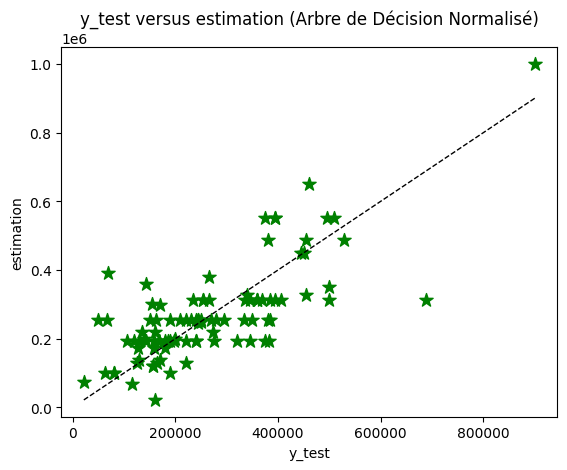

In [37]:
# Q24
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', linewidth=1)
plt.scatter(y_test, y_pred_ad_norm, color='green', marker='*', s=100) 
plt.title("y_test versus estimation (Arbre de Décision Normalisé)")
plt.xlabel("y_test")
plt.ylabel("estimation")
plt.show()

In [38]:
##      Réduction du nombre d’attributs

In [ ]:
# Q25
pca=PCA(n_components=2)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
print(f"Ratio de variance expliquée : {pca.explained_variance_ratio_}")
print(f"Somme du ratio de variance expliquée : {pca.explained_variance_ratio_.sum()}")

Explained Variance Ratio: [0.94237501 0.05689449]
Explained Variance Ratio Sum: 0.9992694969591923


In [40]:
# Q26
ad_norm_pca=make_pipeline(MinMaxScaler(), DecisionTreeRegressor(max_depth=7))
ad_norm_pca.fit(X_train_pca, y_train)
y_pred_pca=ad_norm_pca.predict(X_test_pca)
r2_pca=r2_score(y_test, y_pred_pca)
print("Score R2 après réduction (PCA) :", r2_pca)

Score R2 après réduction (PCA) : 0.19297933041799864


In [41]:
##      Matrice de corrélation

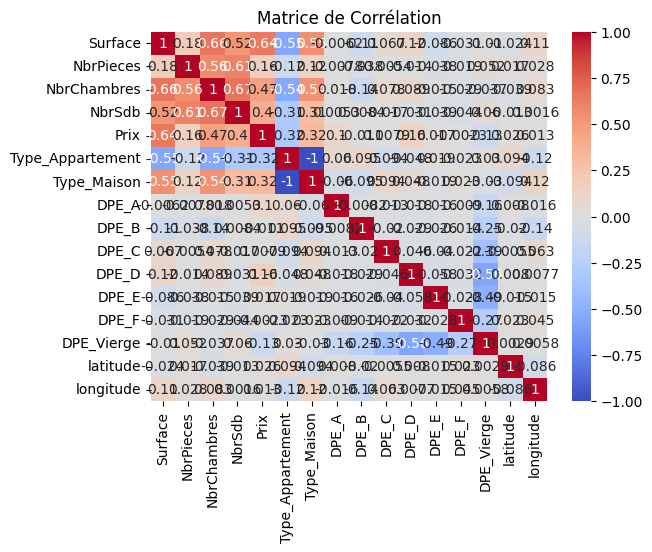

In [45]:
# Q27
corr_matrix=annonces.corr()

sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.title("Matrice de Corrélation")
plt.show()

In [43]:
# Q28
corr_prix=corr_matrix["Prix"].drop("Prix")
max_corr_attr=corr_prix.idxmax()
min_corr_attr=corr_prix.idxmin() 

print(f"L'attribut le plus corrélé positivement avec le prix : {max_corr_attr} ({corr_prix[max_corr_attr]})")
print(f"L'attribut le plus corrélé négativement avec le prix : {min_corr_attr} ({corr_prix[min_corr_attr]})")

L'attribut le plus corrélé positivement avec le prix : Surface (0.6445337734427242)
L'attribut le plus corrélé négativement avec le prix : Type_Appartement (-0.316891489994396)


In [44]:
# Q29

top5_attributs=corr_matrix["Prix"].sort_values(ascending=False).index[1:6] 

annonces_top5_attributs=annonces[top5_attributs.tolist() + ["Prix"]]

X_reduit=annonces_top5_attributs.drop(columns=["Prix"])
y_reduit=annonces_top5_attributs["Prix"]

X_train_red, X_test_red, y_train_red, y_test_red=train_test_split(X_reduit, y_reduit, test_size=0.25, random_state=49)

ad_norm_red=make_pipeline(MinMaxScaler(), DecisionTreeRegressor(max_depth=7))
ad_norm_red.fit(X_train_red, y_train_red)
y_pred_red=ad_norm_red.predict(X_test_red)
r2_reduit=r2_score(y_test_red, y_pred_red)

print("Score R2 après réduction du nombre d'attributs :",r2_reduit)

# On constate que le score R² est inférieur aux scores obtenus précédemment avec l'ensemble des attributs.

Score R2 après réduction du nombre d'attributs : 0.0835739791140121
